In [1]:
import os
from matplotlib import pyplot as plt
import pymatching
import numpy as np
from copy import deepcopy
from types_cfg import *
from circuit_generators import *
from sampling_functions import *
from bitpack import pack_bits, unpack_bits
from circuit_partition import *
from utilities_tf import *
from CNNModel import *


# Number of worker nodes
n_worker_nodes = 8

# Surface code specifications
d = 5
r = 5
kernel_size = 3

# Data types
binary_t, time_t, idx_t, packed_t = get_types(d, r, kernel_size)

# Error probabilities
p = 0.01
before_round_data_depolarization = p
after_reset_flip_probability = p
after_clifford_depolarization = p
before_measure_flip_probability = p

use_rotated_z = True
observable_type = "ZL" if use_rotated_z else "XL"

# Call signatures for functions that require types
call_group_det_bits_kxk = lambda det_bits_dxd, data_bits_dxd=None, d=d, r=r, k=kernel_size, use_rotated_z=use_rotated_z, binary_t=binary_t, idx_t=idx_t, make_translation_map=False: group_det_bits_kxk(det_bits_dxd, d, r, k, use_rotated_z, data_bits_dxd, binary_t, idx_t, make_translation_map)
call_split_measurements = lambda measurements, d=d, idx_t=idx_t: split_measurements(measurements, d, idx_t)

2024-07-11 19:27:36.728136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configure, check for any saved data, and make it if needed.

In [2]:
n_test = 5000000
n_train = 5000000
stim_sampler_seed = 12345
rnd_seed = 12345
n_samples = n_test + n_train

config_name = f"surface_code_d{d}_r{r}_k{kernel_size}_RCNN"
saved_data_dir = f"saved_data/{config_name}/obs_{observable_type}_prob_{str(p).replace('.','p')}"
saved_data_dir = f"{saved_data_dir}_N_{n_samples}_seed_{stim_sampler_seed}"
has_saved_data = os.path.exists(saved_data_dir)
os.makedirs(saved_data_dir, exist_ok=True)

decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = before_round_data_depolarization,
  after_reset_flip_probability = after_reset_flip_probability,
  after_clifford_depolarization = after_clifford_depolarization,
  before_measure_flip_probability = before_measure_flip_probability
)
kernel_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=kernel_size,
  rounds=r,
  before_round_data_depolarization = before_round_data_depolarization,
  after_reset_flip_probability = after_reset_flip_probability,
  after_clifford_depolarization = after_clifford_depolarization,
  before_measure_flip_probability = before_measure_flip_probability
)

# Sampling for the dxd circuit
m_sampler = test_circuit.compile_sampler(seed=stim_sampler_seed)
d_sampler = test_circuit.compile_detector_sampler(seed=stim_sampler_seed)
converter = test_circuit.compile_m2d_converter()
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)

if not has_saved_data:
  measurements = m_sampler.sample(n_samples, bit_packed=False)
  det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
  measurements = measurements.astype(binary_t)
  det_evts = det_evts.astype(binary_t)
  flips = flips.astype(binary_t)

  np.save(f"{saved_data_dir}/measurements.npy", measurements)
  np.save(f"{saved_data_dir}/det_evts.npy", det_evts)
  np.save(f"{saved_data_dir}/flips.npy", flips)
else:
  measurements = np.load(f"{saved_data_dir}/measurements.npy")
  det_evts = np.load(f"{saved_data_dir}/det_evts.npy")
  flips = np.load(f"{saved_data_dir}/flips.npy")

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate for the full circuit: {avg_flips}")

Average flip rate for the full circuit: 0.3546244


In [3]:
print(test_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(9, 1) 9
QUBIT_COORDS(1, 3) 12
QUBIT_COORDS(2, 2) 13
QUBIT_COORDS(3, 3) 14
QUBIT_COORDS(4, 2) 15
QUBIT_COORDS(5, 3) 16
QUBIT_COORDS(6, 2) 17
QUBIT_COORDS(7, 3) 18
QUBIT_COORDS(8, 2) 19
QUBIT_COORDS(9, 3) 20
QUBIT_COORDS(10, 2) 21
QUBIT_COORDS(0, 4) 22
QUBIT_COORDS(1, 5) 23
QUBIT_COORDS(2, 4) 24
QUBIT_COORDS(3, 5) 25
QUBIT_COORDS(4, 4) 26
QUBIT_COORDS(5, 5) 27
QUBIT_COORDS(6, 4) 28
QUBIT_COORDS(7, 5) 29
QUBIT_COORDS(8, 4) 30
QUBIT_COORDS(9, 5) 31
QUBIT_COORDS(1, 7) 34
QUBIT_COORDS(2, 6) 35
QUBIT_COORDS(3, 7) 36
QUBIT_COORDS(4, 6) 37
QUBIT_COORDS(5, 7) 38
QUBIT_COORDS(6, 6) 39
QUBIT_COORDS(7, 7) 40
QUBIT_COORDS(8, 6) 41
QUBIT_COORDS(9, 7) 42
QUBIT_COORDS(10, 6) 43
QUBIT_COORDS(0, 8) 44
QUBIT_COORDS(1, 9) 45
QUBIT_COORDS(2, 8) 46
QUBIT_COORDS(3, 9) 47
QUBIT_COORDS(4, 8) 48
QUBIT_COORDS(5, 9) 49
QUBIT_COORDS(6, 8) 50
QUBIT_COORDS(7, 9) 51
QUBIT_COORDS(8,

In [4]:
print(kernel_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0.

In [5]:
det_bits, _, _ = call_split_measurements(measurements)

In [6]:
# Make sure the data type is np.int32 below, not idx_t!
idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=np.int32), test_size = n_test/n_samples, seed = rnd_seed, shuffle = False)

class_bits = flips
features_det_bits = det_bits
features_det_evts = det_evts

print(class_bits.shape)
print(features_det_bits.shape)
print(features_det_evts.shape)

(10000000, 1)
(10000000, 120)
(10000000, 120)


In [7]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 10:
    return 0.001*(10-epoch)
  elif epoch < 20:
    return lr * 0.9
  elif epoch < 30:
    return lr * 0.8
  else:
    return lr * 0.65

In [8]:
n_nodes = 100
model_dxd = FullRCNNModel(
  observable_type, d, kernel_size, r,
  [n_nodes for _ in range(2)],
  npol=2,
  stop_round = None,
  has_nonuniform_response = False,
  do_all_data_qubits = False,
  return_all_rounds = False
)
model_dxd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dxd([ features_det_bits[0:1], features_det_evts[0:1] ])
model_dxd.summary()

2024-07-11 19:27:54.656925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-11 19:27:54.682696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-11 19:27:54.682921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-11 19:27:54.683812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62


2024-07-11 19:27:56.619267: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-11 19:27:58.001010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Model: "full_rcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rcnn_initial_state_kernel_c  multiple                 8848      
 ombiner (RCNNInitialStateKe                                     
 rnelCombiner)                                                   
                                                                 
 rcnn_lead_in_kernel_combine  multiple                 11870     
 r (RCNNLeadInKernelCombiner                                     
 )                                                               
                                                                 
 rcnn_recurrence_kernel_comb  multiple                 17938     
 iner (RCNNRecurrenceKernelC                                     
 ombiner)                                                        
                                                                 
 rcnn_final_state_kernel_com  multiple             

In [9]:
val_split = 0.2
n_epochs = 50
history = model_dxd.fit(
  x=[ features_det_bits[idxs_train], features_det_evts[idxs_train] ],
  y=class_bits[idxs_train,:],
  batch_size=10000,
  epochs=n_epochs, validation_split=val_split,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
  ]
)

flips_pred = model_dxd.predict(
  [ features_det_bits[idxs_test], features_det_evts[idxs_test] ],
  batch_size=10000
)
print(f"Inaccuracy of the final model on the test data: {(flips[idxs_test]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]}")

Epoch 1/50


2024-07-11 19:32:25.039324: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f05583e5620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-11 19:32:25.039415: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 4g.40gb, Compute Capability 8.0
2024-07-11 19:32:25.044784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 19:32:25.143743: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 535s 655ms/step - loss: 0.4869 - accuracy: 0.7383 - val_loss: 0.3880 - val_accuracy: 0.8083 - lr: 0.0100
Epoch 2/50
400/400 [==============================] - 223s 557ms/step - loss: 0.3388 - accuracy: 0.8400 - val_loss: 0.3007 - val_accuracy: 0.8634 - lr: 0.0090
Epoch 3/50
400/400 [==============================] - 223s 557ms/step - loss: 0.2763 - accuracy: 0.8766 - val_loss: 0.2621 - val_accuracy: 0.8845 - lr: 0.0080
Epoch 4/50
400/400 [==============================] - 223s 558ms/step - loss: 0.2535 - accuracy: 0.8892 - val_loss: 0.2440 - val_accuracy: 0.8936 - lr: 0.0070
Epoch 5/50
400/400 [==============================] - 223s 559ms/step - loss: 0.2409 - accuracy: 0.8955 - val_loss: 0.2401 - val_accuracy: 0.8963 - lr: 0.0060
Epoch 6/50
400/400 [==============================] - 224s 560ms/step - loss: 0.2342 - accuracy: 0.8990 - val_loss: 0.2331 - val_accuracy: 0.8994 - lr: 0.0050
Epoch 7/50
400/400 [==============================] - 222

In [10]:
pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate for the full data set: {np.sum((flips_pred_pym!=flips))/flips_pred_pym.shape[0]}")
flips_pred_pym = pymatcher.decode_batch(det_evts[idxs_test,:], bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate for test data set: {np.sum((flips_pred_pym!=flips[idxs_test,:]))/flips_pred_pym.shape[0]}")

PyMatching error rate for the full data set: 0.0837279
PyMatching error rate for test data set: 0.083535


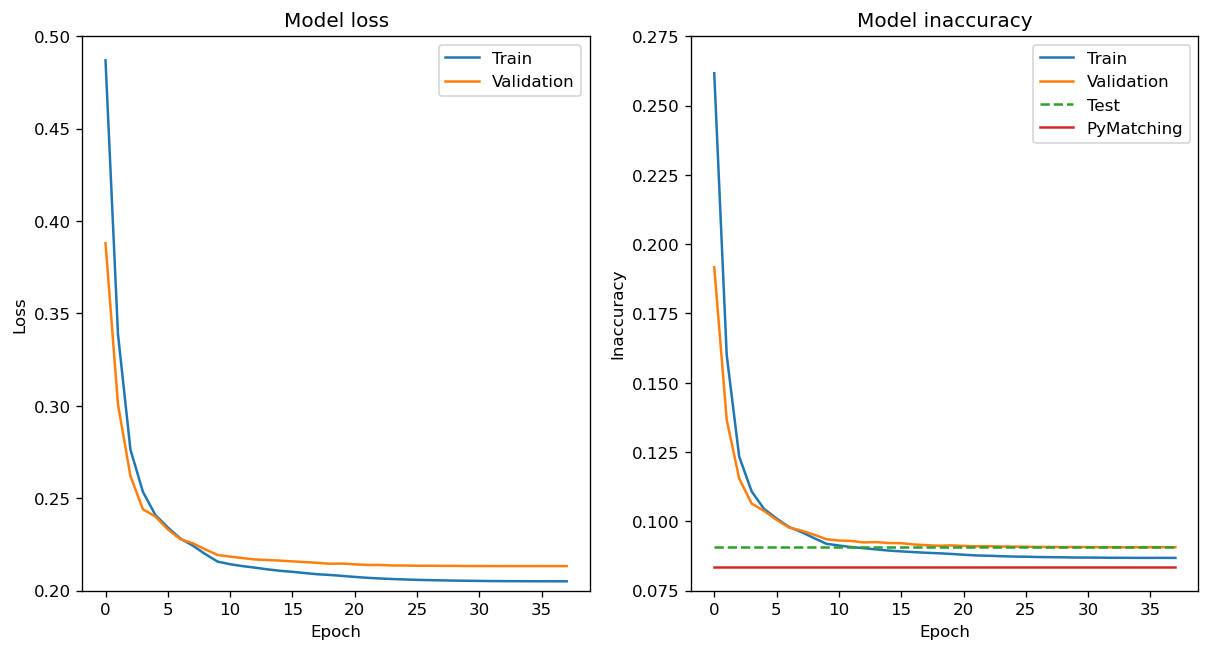

In [14]:
# Plot the training history
# Left panel: loss, right panel: accuracy

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim([0.2, 0.5])
ax[0].legend()

frate = np.sum((flips_pred_pym!=flips[idxs_test,:]))/flips_pred_pym.shape[0]
ftest = (flips[idxs_test]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]
ax[1].plot([1.-x for x in history.history['accuracy']], label='Train')
ax[1].plot([1.-x for x in history.history['val_accuracy']], label='Validation')
ax[1].plot([0, history.epoch[-1]], [ftest]*2, label='Test', linestyle="--")
ax[1].plot([0, history.epoch[-1]], [frate]*2, label='PyMatching')
ax[1].set_title('Model inaccuracy')
ax[1].set_ylabel('Inaccuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim([0.075, 0.275])
ax[1].legend()

fig.set_dpi(120)
plt.show()

In [12]:
model_dxd.save_weights(f"{saved_data_dir}/model_dxd", overwrite=True)

In [15]:
model_dxd.set_rounds(10)

In [20]:
config_name_r10 = f"surface_code_d{d}_r10_k{kernel_size}_RCNN"
saved_data_dir_r10 = f"saved_data/{config_name_r10}/obs_{observable_type}_prob_{str(p).replace('.','p')}"
saved_data_dir_r10 = f"{saved_data_dir_r10}_N_{n_samples}_seed_{stim_sampler_seed}"
has_saved_data_r10 = os.path.exists(saved_data_dir_r10)
if has_saved_data_r10:
  measurements = np.load(f"{saved_data_dir_r10}/measurements.npy")
  det_evts = np.load(f"{saved_data_dir_r10}/det_evts.npy")
  flips = np.load(f"{saved_data_dir_r10}/flips.npy")
  print("Loaded r=10 data...")
  det_bits, _, _ = call_split_measurements(measurements)
  class_bits = flips
  features_det_bits = det_bits
  features_det_evts = det_evts
  flips_pred = model_dxd.predict(
    [ features_det_bits, features_det_evts ],
    batch_size=10000
  )
  print(f"Inaccuracy of the final model on the test data: {(flips!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).mean()}")

Loaded r=10 data...
1000/1000 [==============================] - 614s 493ms/step
Inaccuracy of the final model on the test data: 0.3949639


In [21]:
if has_saved_data_r10:
  test_circuit_r10 = get_builtin_circuit(
    "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
    distance=d,
    rounds=10,
    before_round_data_depolarization = before_round_data_depolarization,
    after_reset_flip_probability = after_reset_flip_probability,
    after_clifford_depolarization = after_clifford_depolarization,
    before_measure_flip_probability = before_measure_flip_probability
  )
  detector_error_model_r10 = test_circuit_r10.detector_error_model(decompose_errors=True)
  pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model_r10)
  flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
  print(f"PyMatching error rate for the r=10 data set: {np.mean((flips_pred_pym!=flips))}")

PyMatching error rate for the r=10 data set: 0.1591241
